# 피지과다

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [2]:
model_name = 'efficientnet-b7'

train_name = 'model2'

In [3]:
# 모델 가중치를 저장할 경로
PATH = './scalp_weights/'

# 데이터셋 경로 설정
train_name = 'model2'
data_train_path = './train_data/' + train_name + '/train'
data_validation_path = './train_data/' + train_name + '/validation'
data_test_path = './train_data/' + train_name + '/test'

# 이미지 크기 설정 (예시로 224x224 사용)
image_size = (224, 224)
num_classes = 5  # 클래스의 개수

# 데이터 로더 설정
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen.flow_from_directory(
    data_train_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_validation_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 56826 images belonging to 5 classes.
Found 16236 images belonging to 5 classes.


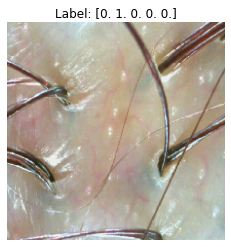

In [4]:
import matplotlib.pyplot as plt

# 데이터셋 로더로부터 배치 데이터 가져오기
batch_images, batch_labels = next(validation_generator)

# 가져온 배치 데이터의 첫 번째 이미지와 라벨 확인
sample_image = batch_images[0]
sample_label = batch_labels[0]

# 이미지 시각화
plt.imshow(sample_image)
plt.title(f"Label: {sample_label}")
plt.axis('off')  # 축 제거
plt.show()

In [5]:
# EfficientNet B7 모델 로딩 (include_top=False로 설정하여 마지막 fully connected layer를 제외합니다)
base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

258088960/258076736 [==============================] - 1s 0us/step


In [6]:
# 입력 데이터 정규화 레이어 추가
inputs = Input(shape=(224, 224, 3))
normalized_inputs = Rescaling(scale=1.0/255.0)(inputs)
x = base_model(normalized_inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [7]:
# 전체 모델 생성
model = Model(inputs=inputs, outputs=predictions)

In [8]:
# EfficientNet의 기존 가중치는 고정하고 새로 추가한 레이어만 학습되도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
1775/1775 [==============================] - 2084s 1s/step - loss: 0.9542 - accuracy: 0.4730 - val_loss: 0.9349 - val_accuracy: 0.4942
Epoch 2/10
1775/1775 [==============================] - 2021s 1s/step - loss: 0.9383 - accuracy: 0.4874 - val_loss: 0.9345 - val_accuracy: 0.4942
Epoch 3/10
1775/1775 [==============================] - 2053s 1s/step - loss: 0.9374 - accuracy: 0.4882 - val_loss: 0.9383 - val_accuracy: 0.4942
Epoch 4/10
1775/1775 [==============================] - 2084s 1s/step - loss: 0.9364 - accuracy: 0.4913 - val_loss: 0.9332 - val_accuracy: 0.4942
Epoch 5/10
1775/1775 [==============================] - 2065s 1s/step - loss: 0.9361 - accuracy: 0.4911 - val_loss: 0.9329 - val_accuracy: 0.4942
Epoch 6/10
1775/1775 [==============================] - 2035s 1s/step - loss: 0.9361 - accuracy: 0.4916 - val_loss: 0.9337 - val_accuracy: 0.4942
Epoch 7/10
1775/1775 [==============================] - 2001s 1s/step - loss: 0.9362 - accuracy: 0.4919 - val_loss: 0.9334 -

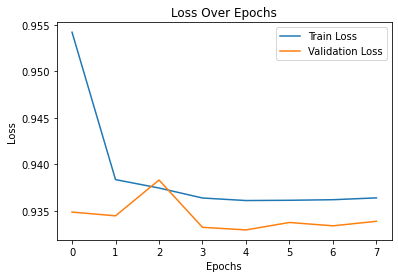

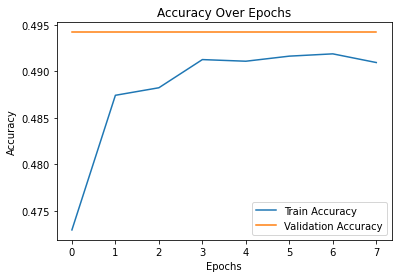

In [14]:
# 학습 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.show()

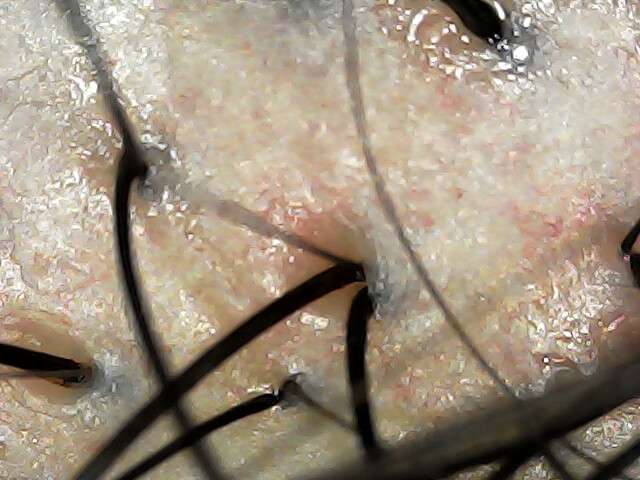

예측된 클래스: 2


In [28]:
from PIL import Image
import os
import numpy as np

data_test_path = './train_data/model2/test'  # 이미지 파일의 실제 경로로 바꿔주세요

# 이미지 파일 목록 가져오기
image_list = os.listdir(data_test_path)

# 첫 번째 이미지 파일 열기
if len(image_list) > 0:
    first_image_path = os.path.join(data_test_path, image_list[0])
    image = Image.open(first_image_path)
    
    # 이미지 보여주기
    image.show()
        
    # 이미지를 모델 입력 크기에 맞게 조정
    image = image.resize((224, 224))  # 모델 입력 크기에 맞게 조정
    image_array = np.array(image) / 255.0  # 이미지를 0에서 1 사이 값으로 변환
    image_array = np.expand_dims(image_array, axis=0)  # 배치 차원 추가

    # 모델로 이미지 분류
    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction)

    print(f"예측된 클래스: {predicted_class}")
else:
    print("폴더에 이미지 파일이 없습니다.")